<a href="https://colab.research.google.com/github/rodsei/pattern-recognition/blob/main/Reconhecimento_de_padr%C3%B5es_%C3%81rvores_de_Decis%C3%A3o_Tarefa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade da semana 5 - Árvores de Decisão

1. Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

2. Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

3. Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

4. Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

#### Imports

In [1]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

## Download da base de dados: Iris


In [2]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
X, y = iris.data[:,2:], iris.target
X.shape, y.shape

((150, 2), (150,))

In [4]:
combinacoes = 1
for i in range(X.shape[1]):
    valores = set(X[:,i])
    combinacoes *= len(valores)
    print(valores)
print(combinacoes)

{1.7, 1.4, 1.6, 1.3, 1.5, 1.1, 1.2, 1.0, 1.9, 4.7, 4.5, 4.9, 4.0, 5.0, 6.0, 3.5, 3.0, 4.6, 4.4, 4.1, 5.1, 5.9, 5.6, 5.5, 5.4, 6.6, 6.1, 6.9, 6.4, 3.6, 3.3, 3.8, 3.7, 4.2, 4.8, 4.3, 5.8, 5.3, 5.7, 5.2, 6.3, 6.7, 3.9}
{0.2, 0.4, 0.3, 0.5, 0.6, 1.4, 1.5, 1.3, 1.6, 1.0, 1.1, 2.5, 2.0, 2.1, 1.2, 1.7, 0.1, 2.2, 2.3, 1.8, 1.9, 2.4}
946


In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

## Comparando com a implementação dos vídeos da aula e com a implementação do scikit learn.


### Criando uma heurísica

In [6]:
def minha_impureza(y): #Entropia
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        distribuicao = sum(y==k)/len(y)
        probabilidades[i] = (distribuicao)*np.log2(distribuicao)
    result = -1 * sum(probabilidades)
    return result

ytmp = y[:]
valor = minha_impureza(ytmp)
valor

1.584962500721156

In [7]:
def minha_impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = minha_impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = minha_impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores
minha_impurezaValor(X[:,0], y, 2.5)

(0.6666666666666666, 1.0, -0.0)

In [8]:
def meu_melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = np.median(x) # Usando um valor fixo da mediana
        
        # valor = np.random.uniform(low=xmin,high=xmax) # Testando um valor aleatório entre xmin e xmax
        impTotal, impMaiores, impMenores = minha_impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza
meu_melhorValor(X[:,0], y)

(4.35, 0.9182958340544896)

In [9]:
def minha_melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = meu_melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
print(minha_melhorCaracteristica(X,y))

(1, 1.3, 0.9159794717999729)


In [10]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Minha_Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = minha_melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Minha_Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Minha_Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Minha_Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

### Implementação dos Vídeos da Aula

In [11]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

ytmp = y[:]
valor = impureza(ytmp)
valor

0.6666666666666667

In [12]:
def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores
impurezaValor(X[:,0], y, 2.5)

(0.3333333333333333, 0.5, 0.0)

In [13]:
def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        # print(f"Melhor Valor: {valor:6}")
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        # print(f"Impurezas: Total {impTotal:4} | > {impMaiores: 4}  |  <{impMenores: 4}")
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza
melhorValor(X[:,0], y)

(2.475, 0.3333333333333333)

In [14]:
def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
print(melhorCaracteristica(X,y))

(0, 2.475, 0.3333333333333333)


In [15]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

### Plotando as regiões de decisão

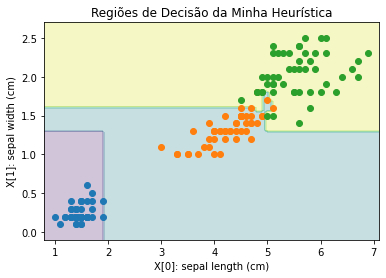

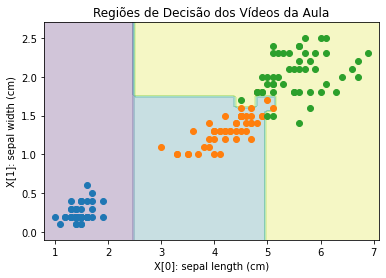

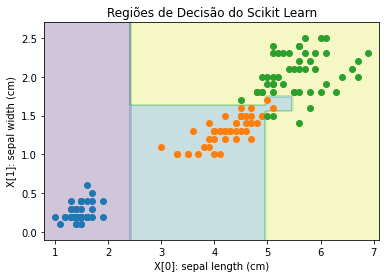

In [16]:
def plotDecisao_Iris(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.title(title)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

plotDecisao_Iris(Minha_Arvore(), X, y, "Regiões de Decisão da Minha Heurística")

plotDecisao_Iris(Arvore(), X, y, "Regiões de Decisão dos Vídeos da Aula")

plotDecisao_Iris(DecisionTreeClassifier(), X, y, "Regiões de Decisão do Scikit Learn")

### Comparando os Resultados

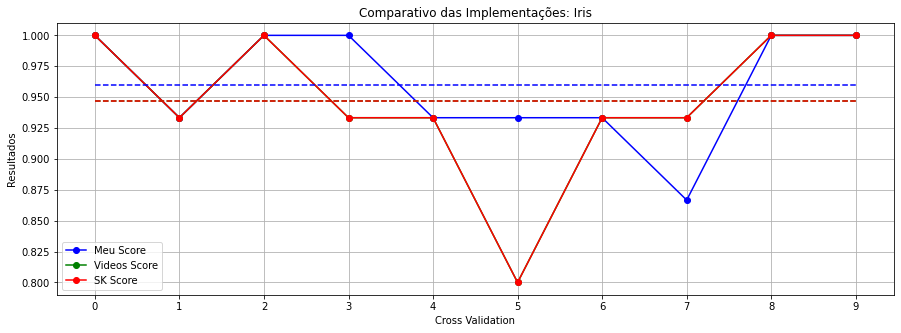

Média dos resultados:
   Meus scores: 96.00000000000001
  Vídeo scores: 94.66666666666667
Sklearn scores: 94.66666666666667


In [17]:
def plotCrossValidationResults(X, y, cross_validations, dataset_name):
  plt.figure(figsize=(15,5))

  meus_scores = cross_validate(Minha_Arvore(), X, y, cv=cross_validations)
  videos_scores = cross_validate(Arvore(), X, y, cv=cross_validations)
  sk_scores = cross_validate(DecisionTreeClassifier(), X, y, cv=cross_validations)

  runs = range(cross_validations)

  # Plot Cross Validation Results
  plt.plot(runs, meus_scores["test_score"], marker='o', label="Meu Score", color="b") 
  plt.plot(runs, videos_scores["test_score"], marker='o', label="Videos Score", color="g")
  plt.plot(runs, sk_scores["test_score"], marker='o', label="SK Score", color="r")

  #Plot Means
  plt.plot(runs,[np.mean(meus_scores["test_score"])]*len(runs), label='Meu Score Mean', linestyle='--', color="b")
  plt.plot(runs,[np.mean(videos_scores["test_score"])]*len(runs), label='Videos Score Mean', linestyle='--', color="g")
  plt.plot(runs,[np.mean(sk_scores["test_score"])]*len(runs), label='SK Score Mean', linestyle='--', color="r")

  plt.legend(labels=["Meu Score", "Videos Score", "SK Score"])
  plt.title(f"Comparativo das Implementações: {dataset_name}")
  plt.ylabel("Resultados")
  plt.xlabel("Cross Validation")
  plt.xticks(runs)
  plt.grid()
  plt.show()
  return np.mean(meus_scores["test_score"]), np.mean(videos_scores["test_score"]), np.mean(sk_scores["test_score"])

mean_ms, mean_vs, mean_sks = plotCrossValidationResults(X, y, 10, "Iris")
print("Média dos resultados:")
print(f"   Meus scores: {mean_ms*100}")
print(f"  Vídeo scores: {mean_vs*100}")
print(f"Sklearn scores: {mean_sks*100}")

## Comparando as implementações em outras bases de classificação com atributos contínuos

### Base de dados 1: Seeds

#### Download

In [18]:
!wget https://www.dropbox.com/s/yysca5faub2l670/seeds_dataset.txt?dl=0 -O seeds_database.txt

--2020-12-17 23:17:07--  https://www.dropbox.com/s/yysca5faub2l670/seeds_dataset.txt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yysca5faub2l670/seeds_dataset.txt [following]
--2020-12-17 23:17:07--  https://www.dropbox.com/s/raw/yysca5faub2l670/seeds_dataset.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6a306672e3d8cd35fe1ea27dcc.dl.dropboxusercontent.com/cd/0/inline/BFSvg_MhFKCQeMJoPeH0uOpbjK7ExKalvDovJHxZr8JBi-f8TM8gTJpzslKjSUnECT9jOBuVtrXmllVCgwO_-MvpLG9_U_7Yeqi3g-LH_bm48zh6m9VgjxxQILT8I5Wibz0/file# [following]
--2020-12-17 23:17:07--  https://uc6a306672e3d8cd35fe1ea27dcc.dl.dropboxusercontent.com/cd/0/inline/BFSvg_MhFKCQeMJoPeH0uOpbjK7ExKalvDovJHxZr8JBi-f8TM8gTJpzslKjSUnECT9jOBuVtrXmllVCgwO_-MvpLG9

#### Detalhes

In [19]:
import pandas as pd
import numpy as np

seeds_db = pd.read_csv("seeds_database.txt", sep="\t", header=None,
                          names=["Area", "Perimeter", "Compactness", 
                                 "Length of Kernel", "Width of Kernel",
                                 "Asymetry Coefficient", "Length of Kernel Groove",
                                 "Variety"])

seeds_db

,Area,Perimeter,Compactness,Length of Kernel,Width of Kernel,Asymetry Coefficient,Length of Kernel Groove,Variety
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [20]:
for column in seeds_db.columns:
  print(f"{column:>25}: {len(set(seeds_db[column])):5} - {seeds_db[column].dtype}")

                     Area:   193 - float64
                Perimeter:   170 - float64
              Compactness:   186 - float64
         Length of Kernel:   188 - float64
          Width of Kernel:   184 - float64
     Asymetry Coefficient:   207 - float64
  Length of Kernel Groove:   148 - float64
                  Variety:     3 - int64


In [21]:
# Possíveis comparações:
# Area, Asymetry Coefficient
# Perimeter, Asymetry Coefficient
# Area, Length of Kernel Groove
# MAIS INTERESSANTE: Length of Kernel, Length of Kernel Groove 

seeds = seeds_db[["Length of Kernel", "Length of Kernel Groove"]]
seeds_X = np.array(seeds)
seeds_y = np.array(seeds_db["Variety"].values)

seeds_X.shape, seeds_y.shape, np.transpose(set(seeds_y))

((210, 2), (210,), array({1, 2, 3}, dtype=object))

#### Escolha da melhor característica


In [22]:
minha_melhor_feature = minha_melhorCaracteristica(seeds_X, seeds_y)
videos_melhor_feature = melhorCaracteristica(seeds_X, seeds_y)

sk_tree = DecisionTreeClassifier()
sk_tree.fit(seeds_X,seeds_y)
sk_melhor_feature = np.argmax(sk_tree.feature_importances_), max(sk_tree.feature_importances_), sk_tree.tree_.impurity[np.argmax(sk_tree.feature_importances_)]

minha_melhor_feature, videos_melhor_feature, sk_melhor_feature

((0, 5.5235, 1.0164993396796866),
 (1, 5.5344999999999995, 0.35440435810463555),
 (1, 0.7018134536557716, 0.5138574518384387))

#### Regiões de Decisão

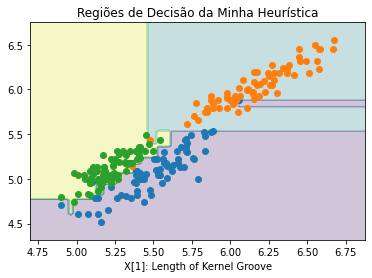

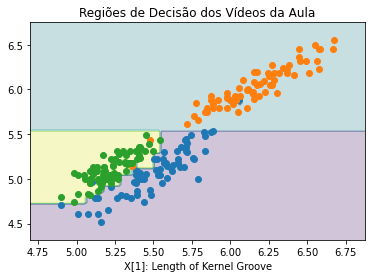

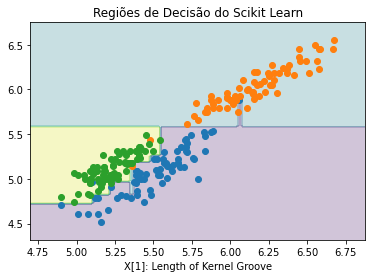

In [23]:
def plotDecisao_Seeds(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.title(title)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{seeds_y[k]} [{k}]")
    plt.xlabel(f"X[0]: {seeds.keys()[0]}")
    plt.xlabel(f"X[1]: {seeds.keys()[1]}")
    plt.show()


plotDecisao_Seeds(Minha_Arvore(), seeds_X, seeds_y, "Regiões de Decisão da Minha Heurística")
plotDecisao_Seeds(Arvore(), seeds_X, seeds_y, "Regiões de Decisão dos Vídeos da Aula")
plotDecisao_Seeds(DecisionTreeClassifier(), seeds_X, seeds_y, "Regiões de Decisão do Scikit Learn")

#### Comparação de Resultados

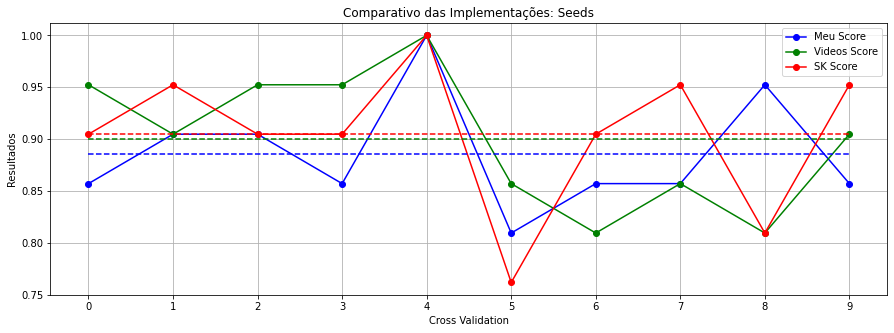

Média dos resultados:
   Meus scores: 88.57142857142858
  Vídeo scores: 90.0
Sklearn scores: 90.47619047619048


In [24]:
mean_ms, mean_vs, mean_sks = plotCrossValidationResults(seeds_X, seeds_y, 10, "Seeds")
print("Média dos resultados:")
print(f"   Meus scores: {mean_ms*100}")
print(f"  Vídeo scores: {mean_vs*100}")
print(f"Sklearn scores: {mean_sks*100}")

### Base de dados 2: Breast Cancer Wisconsin (Original)

#### Download

In [25]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

--2020-12-17 23:17:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19889 (19K) [application/x-httpd-php]
Saving to: ‘breast-cancer-wisconsin.data.9’

breast-cancer-wisco 100%[===================>]  19.42K  --.-KB/s    in 0.01s   

2020-12-17 23:17:11 (1.86 MB/s) - ‘breast-cancer-wisconsin.data.9’ saved [19889/19889]



#### Detalhes

In [26]:
import pandas as pd
import numpy as np

wisconsin_db = pd.read_csv("breast-cancer-wisconsin.data", sep=",", header=None, 
             names=["Sample Code", "Clump Thickness", "Uniformity of Cell Size", 
                    "Uniformity of Cell Shape", "Marginal Adhesion", 
                    "Single Epithelial Cell Size", "Bare Nuclei", 
                    "Bland Chromatin", "Normal Nucleoli", "Mitoses", "Class"])
wisconsin_db

,Sample Code,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [27]:
for column in wisconsin_db.columns:
  print(f"{column:>30}: {len(set(wisconsin_db[column])):3} {wisconsin_db[column].dtype}")

                   Sample Code: 645 int64
               Clump Thickness:  10 int64
       Uniformity of Cell Size:  10 int64
      Uniformity of Cell Shape:  10 int64
             Marginal Adhesion:  10 int64
   Single Epithelial Cell Size:  10 int64
                   Bare Nuclei:  11 object
               Bland Chromatin:  10 int64
               Normal Nucleoli:  10 int64
                       Mitoses:   9 int64
                         Class:   2 int64


In [28]:
wisconsin = wisconsin_db[["Clump Thickness", "Uniformity of Cell Size"]]

wisconsin_X = np.array(wisconsin)
wisconsin_y = np.array(wisconsin_db["Class"].values)

wisconsin_X.shape, wisconsin_y.shape, np.transpose(set(wisconsin_y))

((699, 2), (699,), array({2, 4}, dtype=object))

#### Escolha da melhor característica

In [29]:
minha_melhor_feature = minha_melhorCaracteristica(wisconsin_X, wisconsin_y)
videos_melhor_feature = melhorCaracteristica(wisconsin_X, wisconsin_y)

sk_tree = DecisionTreeClassifier()
sk_tree.fit(wisconsin_X,wisconsin_y)
sk_melhor_feature = np.argmax(sk_tree.feature_importances_), max(sk_tree.feature_importances_), sk_tree.tree_.impurity[np.argmax(sk_tree.feature_importances_)]

minha_melhor_feature, videos_melhor_feature, sk_melhor_feature

((1, 1.0, 0.40978179090559913),
 (0, 5.5, 0.2385401230294857),
 (1, 0.8991662325930162, 0.05437918724632007))

#### Regiões de Decisão

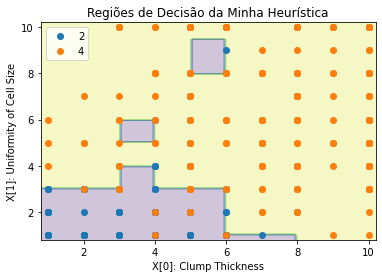

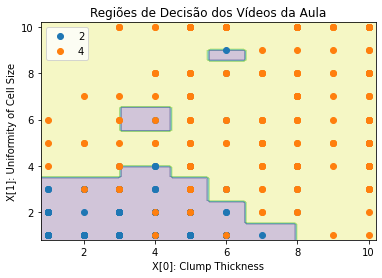

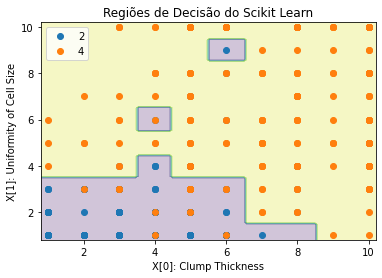

In [30]:
def plotDecisao_Wisconsin(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.title(title)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{wisconsin_y[k]} [{k}]")
    plt.legend(set(y))
    plt.xlabel(f"X[0]: {wisconsin.keys()[0]}")
    plt.ylabel(f"X[1]: {wisconsin.keys()[1]}")
    plt.show()


plotDecisao_Wisconsin(Minha_Arvore(), wisconsin_X, wisconsin_y, "Regiões de Decisão da Minha Heurística")
plotDecisao_Wisconsin(Arvore(), wisconsin_X, wisconsin_y, "Regiões de Decisão dos Vídeos da Aula")
plotDecisao_Wisconsin(DecisionTreeClassifier(), wisconsin_X, wisconsin_y, "Regiões de Decisão do Scikit Learn")

#### Comparação de Resultados

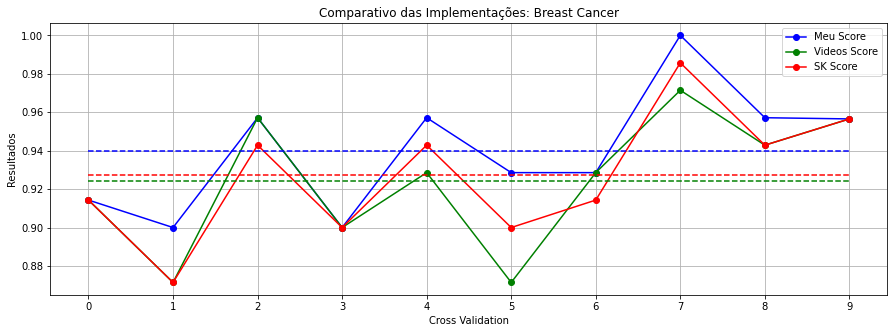

Média dos resultados:
   Meus scores: 93.99378881987579
  Vídeo scores: 92.42236024844722
Sklearn scores: 92.7080745341615


In [31]:
mean_ms, mean_vs, mean_sks = plotCrossValidationResults(wisconsin_X, wisconsin_y, 10, "Breast Cancer")
print("Média dos resultados:")
print(f"   Meus scores: {mean_ms*100}")
print(f"  Vídeo scores: {mean_vs*100}")
print(f"Sklearn scores: {mean_sks*100}")

### Base de dados 3: Cryotherapy

#### Download

In [32]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00429/Cryotherapy.xlsx

--2020-12-17 23:17:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00429/Cryotherapy.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33589 (33K) [application/x-httpd-php]
Saving to: ‘Cryotherapy.xlsx.7’

Cryotherapy.xlsx.7  100%[===================>]  32.80K  --.-KB/s    in 0.01s   

2020-12-17 23:17:15 (2.80 MB/s) - ‘Cryotherapy.xlsx.7’ saved [33589/33589]



#### Detalhes

In [33]:
import pandas as pd
import numpy as np

cryotherapy_db = pd.read_excel("Cryotherapy.xlsx",usecols="A:G")

cryotherapy_db

,sex,age,Time,Number_of_Warts,Type,Area,Result_of_Treatment
0,1,35,12.00,5,1,100,0
1,1,29,7.00,5,1,96,1
2,1,50,8.00,1,3,132,0
3,1,32,11.75,7,3,750,0
4,1,67,9.25,1,1,42,0
...,...,...,...,...,...,...,...
85,2,34,12.00,3,3,95,0
86,2,20,3.50,6,1,75,1
87,2,35,8.25,8,3,100,0
88,1,24,10.75,10,1,20,1


In [34]:
for column in cryotherapy_db.columns:
  print(f"{column:>20}: {len(set(cryotherapy_db[column])):3} {cryotherapy_db[column].dtype}")

                 sex:   2 int64
                 age:  24 int64
                Time:  36 float64
     Number_of_Warts:  12 int64
                Type:   3 int64
                Area:  22 int64
 Result_of_Treatment:   2 int64


In [35]:
cryotherapy = cryotherapy_db[["Time","Number_of_Warts"]]

cryotherapy_X = np.array(cryotherapy)
cryotherapy_y = np.array(cryotherapy_db["Result_of_Treatment"].values)

cryotherapy_X.shape, cryotherapy_y.shape, np.transpose(set(cryotherapy_y))

((90, 2), (90,), array({0, 1}, dtype=object))

#### Escolha da melhor Característica

In [36]:
minha_melhor_feature = minha_melhorCaracteristica(cryotherapy_X, cryotherapy_y)
videos_melhor_feature = melhorCaracteristica(cryotherapy_X, cryotherapy_y)

sk_tree = DecisionTreeClassifier()
sk_tree.fit(cryotherapy_X,cryotherapy_y)
sk_melhor_feature = np.argmax(sk_tree.feature_importances_), max(sk_tree.feature_importances_), sk_tree.tree_.impurity[np.argmax(sk_tree.feature_importances_)]

minha_melhor_feature, videos_melhor_feature, sk_melhor_feature

((0, 8.5, 0.6199404705213222),
 (0, 6.125, 0.32387955182072836),
 (0, 0.8149995448476758, 0.49777777777777776))

#### Regiões de Decisão

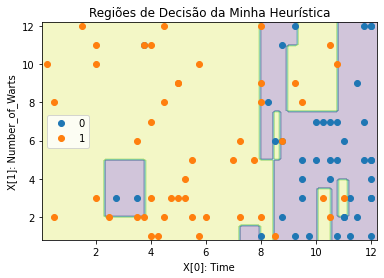

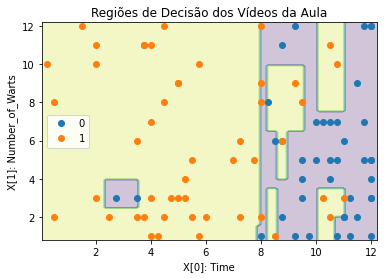

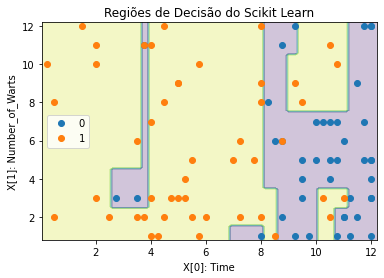

In [37]:
def plotDecisao_Cryotherapy(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.title(title)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{cryotherapy_y[k]} [{k}]")
    plt.legend(set(y))
    plt.xlabel(f"X[0]: {cryotherapy.keys()[0]}")
    plt.ylabel(f"X[1]: {cryotherapy.keys()[1]}")
    plt.show()


plotDecisao_Cryotherapy(Minha_Arvore(), cryotherapy_X, cryotherapy_y, "Regiões de Decisão da Minha Heurística")
plotDecisao_Cryotherapy(Arvore(), cryotherapy_X, cryotherapy_y, "Regiões de Decisão dos Vídeos da Aula")
plotDecisao_Cryotherapy(DecisionTreeClassifier(), cryotherapy_X, cryotherapy_y, "Regiões de Decisão do Scikit Learn")

#### Comparação de Resultados

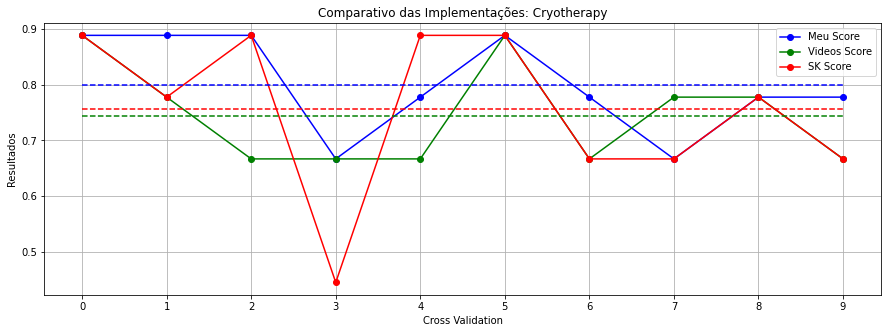

Média dos resultados:
   Meus scores: 80.0
  Vídeo scores: 74.44444444444444
Sklearn scores: 75.55555555555556


In [38]:
mean_ms, mean_vs, mean_sks = plotCrossValidationResults(cryotherapy_X, cryotherapy_y, 10, "Cryotherapy")
print("Média dos resultados:")
print(f"   Meus scores: {mean_ms*100}")
print(f"  Vídeo scores: {mean_vs*100}")
print(f"Sklearn scores: {mean_sks*100}")

# Interpretação dos resultados

Pequenos ajustes realizados na implementação da heurística mudam consideravelmente os resultados, podendo se sobressair à implementação padrão do Scikit Learn ou chegar a resultados muito inferiores. Foram testadas algumas formas de se dividir os nós. De forma surpreendente, os melhores resultados foram obtidos com a utilização de um valor fixo (mediana de X) e dessa forma, os resultados médios da validação cruzada ficaram próximos, sem a ocorrência de overfit. Outro ponto que pôde ser observado, é que em uma das bases, a mesma implementação da heurítica criada obteve resultados piores. Isso mostra que não importa como o modelo está ajustado, ele terá comportamentos distintos dependendo da base de dados e dos atributos que estão sendo utilizados. A utilização de mais atributos para uma árvore de decisão pode aumentar o desempenho do classificador, considerando que o algoritmo terá mais pontos de decisão para fazer a separação dos nós e uma abrangência maior de possibilidades com menor impureza nos momentos de decisão.

Lendo sobre os graus de impureza nas árvores de classificação com partições binárias, encontrei uma comparação entre o critério de Gini, que tende a isolar num ramo os registros que representam a classe mais freqüente e a Entropia, que tende a balancear o número de registros em cada ramo. Somente com a visualização das regiões de decisão, não consegui observar esse comportamento, mas em uma base de dados com uma classe minoritária, acredito que esse comportamento pode se tornar visível.